In [ ]:
# Jaya Algorithm in Julia for Structural Design Optimization

using Random
using Printf
using Plots


In [9]:
# Constants
sigma = 6         # allowable stress (kN/cm²)
E = 20000         # modulus of elasticity (kN/cm²)
P = 600           # vertical load (kN)
L = 200           # beam length (cm)

# Algorithm parameters
maxiter = 200
pn = 15

# Variable bounds
hmin, hmax = 10.0, 80.0
bmin, bmax = 10.0, 50.0
twmin, twmax = 0.9, 5.0
tfmin, tfmax = 0.9, 5.0;

In [10]:

# Initialize population
OPT = zeros(7, pn)
for i in 1:pn
    h = hmin + (hmax - hmin) * rand()
    b = bmin + (bmax - bmin) * rand()
    tw = twmin + (twmax - twmin) * rand()
    tf = tfmin + (tfmax - tfmin) * rand()

    I = (tw * (h - 2 * tf)^3) / 12 + (b * tf^3) / 6 + 2 * b * tf * ((h - tf)/2)^2
    Fx = 5000 / I
    g1 = 2 * b * tf + tw * (h - 2 * tf)

    denom = tw * (h - 2 * tf)^3 + 2 * b * tf * (4 * tf^2 + 3 * h * (h - 2 * tf)) +
            tw^3 * (h - 2 * tf) + 2 * tw * b^3
    g2 = (18000 * h + 15000 * b) / denom

    if g1 > 300 || g2 > 6
        Fx = 1e6
    end

    OPT[:, i] .= [h, b, tw, tf, Fx, g1, g2]
end

# Store best value at each iteration
best_history = zeros(maxiter);

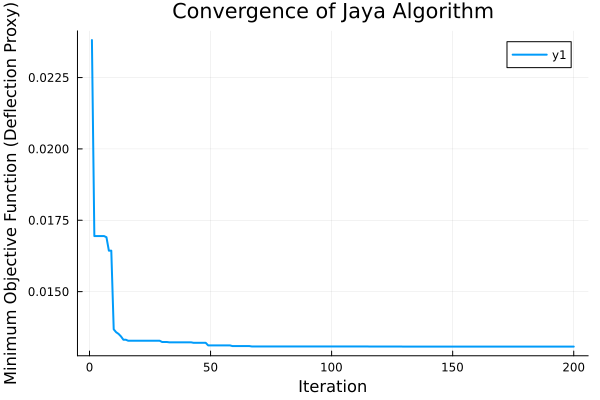


🏆 Best Design Found:
Height h       = 80.0000 cm
Width b        = 50.0000 cm
Web thickness  = 0.9000 cm
Flange thickness = 2.3218 cm
Objective (Deflection Proxy) = 0.013074
Constraint g1 (area) = 300.0000 cm^2
Constraint g2 (stress) = 0.4549 kN/cm^2


In [12]:

# Main loop
for iter in 1:maxiter
    OPT1 = zeros(7, pn)
    r = argmin(OPT[5, :])
    t = argmax(OPT[5, :])
    best = OPT[1:4, r]
    worst = OPT[1:4, t]

    for i in 1:pn
        current = OPT[1:4, i]
        r1 = rand(4)
        r2 = rand(4)
        new = current .+ r1 .* (best .- abs.(current)) .- r2 .* (worst .- abs.(current))

        # Enforce bounds
        new[1] = clamp(new[1], hmin, hmax)
        new[2] = clamp(new[2], bmin, bmax)
        new[3] = clamp(new[3], twmin, twmax)
        new[4] = clamp(new[4], tfmin, tfmax)

        h, b, tw, tf = new

        I = (tw * (h - 2 * tf)^3) / 12 + (b * tf^3) / 6 + 2 * b * tf * ((h - tf)/2)^2
        Fx = 5000 / I
        g1 = 2 * b * tf + tw * (h - 2 * tf)

        denom = tw * (h - 2 * tf)^3 + 2 * b * tf * (4 * tf^2 + 3 * h * (h - 2 * tf)) +
                tw^3 * (h - 2 * tf) + 2 * tw * b^3
        g2 = (18000 * h + 15000 * b) / denom

        if g1 > 300 || g2 > 6
            Fx = 1e6
        end

        OPT1[:, i] .= [h, b, tw, tf, Fx, g1, g2]
    end

    # Replacement
    for i in 1:pn
        if OPT1[5, i] < OPT[5, i]
            OPT[:, i] .= OPT1[:, i]
        end
    end

    best_history[iter] = minimum(OPT[5, :])
end


# Plot convergence
plt= plot(best_history, lw=2, xlabel="Iteration", ylabel="Minimum Objective Function (Deflection Proxy)",
     title="Convergence of Jaya Algorithm", grid=true)

display(plt)

# Show final best design
idx_best = argmin(OPT[5, :])
final = OPT[:, idx_best]
println("\n🏆 Best Design Found:")
@printf("Height h       = %.4f cm\n", final[1])
@printf("Width b        = %.4f cm\n", final[2])
@printf("Web thickness  = %.4f cm\n", final[3])
@printf("Flange thickness = %.4f cm\n", final[4])
@printf("Objective (Deflection Proxy) = %.6f\n", final[5])
@printf("Constraint g1 (area) = %.4f cm^2\n", final[6])
@printf("Constraint g2 (stress) = %.4f kN/cm^2\n", final[7])

